In [60]:

import numpy as np
import pandas as pd
import yfinance as yf
import pandas_datareader.data as web
import pandas_ta as ta
import matplotlib.pyplot as plt
from datetime import date
plt.style.use('fivethirtyeight')
yf.pdr_override()

stocksymbols = ['UTIAMC.NS']
startdate = date(2017,8,4)
end_date = date.today()
print(end_date)
def getMyPortfolio(stocks = stocksymbols ,start = startdate , end = end_date):
    data = web.get_data_yahoo(stocks , start = start ,end= end )
    return data

data = getMyPortfolio(stocksymbols)

2023-01-01
[*********************100%***********************]  1 of 1 completed


In [61]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-10-13,477.899994,517.500000,477.000000,514.500000,481.252899,3544691
2020-10-14,517.900024,517.900024,500.200012,509.100006,476.201843,766445
2020-10-15,509.500000,514.450012,495.250000,499.000000,466.754486,529121
2020-10-16,504.899994,508.000000,493.100006,502.649994,470.168640,336219
2020-10-19,502.950012,506.100006,490.100006,496.149994,464.088684,494255
...,...,...,...,...,...,...
2022-12-26,827.099976,893.950012,816.099976,868.450012,868.450012,717324
2022-12-27,868.450012,884.900024,850.049988,876.200012,876.200012,314194
2022-12-28,874.799988,878.299988,859.000000,870.549988,870.549988,176989


In [62]:
########### Simple Moving Average Implementation #############

data['SMA 30'] = ta.sma(data['Close'],30)
data['SMA 100'] = ta.sma(data['Close'],100)
#SMA BUY SELL
#Function for buy and sell signal
def buy_sell(data):
    signalBuy = []
    signalSell = []
    position = False 

    for i in range(len(data)):
        if data['SMA 30'][i] > data['SMA 100'][i]:
            if position == False :
                signalBuy.append(data['Adj Close'][i])
                signalSell.append(np.nan)
                position = True
            else:
                signalBuy.append(np.nan)
                signalSell.append(np.nan)
        elif data['SMA 30'][i] < data['SMA 100'][i]:
            if position == True:
                signalBuy.append(np.nan)
                signalSell.append(data['Adj Close'][i])
                position = False
            else:
                signalBuy.append(np.nan)
                signalSell.append(np.nan)
        else:
            signalBuy.append(np.nan)
            signalSell.append(np.nan)
    return pd.Series([signalBuy, signalSell])


data['Buy_Signal_price'], data['Sell_Signal_price'] = buy_sell(data)

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

plot1 = go.Scatter(y=data['Adj Close'],x=data.index, name='Close')
plot2 = go.Scatter(y=data['SMA 30'],x=data.index,name='SMA 30', marker_color='orange')
plot3 = go.Scatter(y=data['SMA 100'],x=data.index,name='SMA 100', marker_color='black')
plot4 = go.Scatter(y=data['Buy_Signal_price'],x=data.index,name='Buy', mode='markers', marker=dict(
        color='green', symbol=45, size=10
    ))
plot5 = go.Scatter(y=data['Sell_Signal_price'],x=data.index,name='Sell', mode='markers', marker=dict(
        color='red', symbol=46, size=10
    ))

fig = make_subplots(shared_xaxes=True, shared_yaxes=True)
fig.add_trace(plot1)
fig.add_trace(plot2)
fig.add_trace(plot3)
fig.add_trace(plot4)
fig.add_trace(plot5)

fig.update_layout(
    title=str(stocksymbols[0]) + ' SMA 30 & SMA 100',
    xaxis_title="Date", yaxis_title="Price",
    legend=dict(yanchor="top", y=0.99, xanchor="right", x=0.99, bordercolor='#1E3163', borderwidth=1),
    width=1200, height=500, plot_bgcolor = '#F8F8F8',
    margin=dict(l=0, r=0, b=0, t=30, pad=0)
)

fig.show()

/tmp/ipykernel_19458/2753185171.py:59: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.



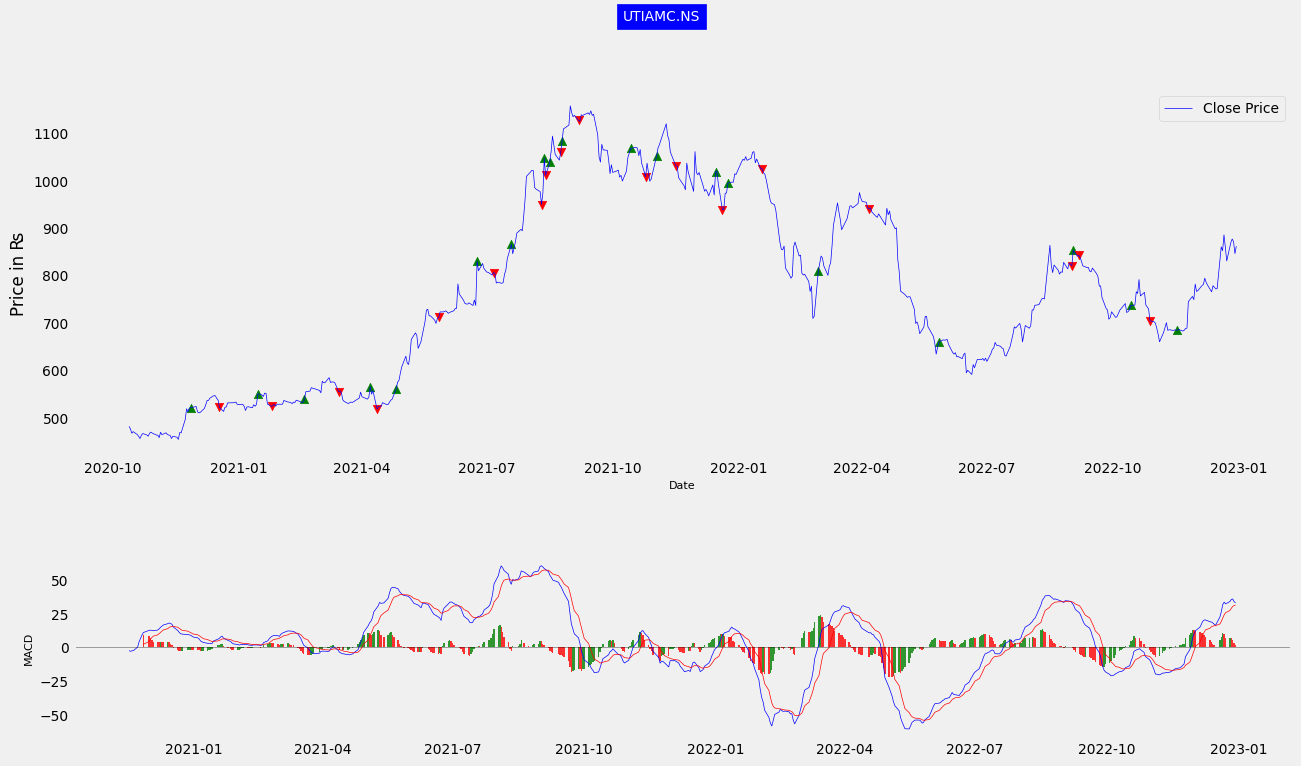

In [63]:
########### MACD Implementation #############

macd = ta.macd(data['Close'])

data = pd.concat([data, macd], axis=1).reindex(data.index)

def MACD_Strategy(df, risk):
    MACD_Buy=[]
    MACD_Sell=[]
    position=False

    for i in range(0, len(df)):
        if df['MACD_12_26_9'][i] > df['MACDs_12_26_9'][i] :
            MACD_Sell.append(np.nan)
            if position ==False:
                MACD_Buy.append(df['Adj Close'][i])
                position=True
            else:
                MACD_Buy.append(np.nan)
        elif df['MACD_12_26_9'][i] < df['MACDs_12_26_9'][i] :
            MACD_Buy.append(np.nan)
            if position == True:
                MACD_Sell.append(df['Adj Close'][i])
                position=False
            else:
                MACD_Sell.append(np.nan)
        elif position == True and df['Adj Close'][i] < MACD_Buy[-1] * (1 - risk):
            MACD_Sell.append(df["Adj Close"][i])
            MACD_Buy.append(np.nan)
            position = False
        elif position == True and df['Adj Close'][i] < df['Adj Close'][i - 1] * (1 - risk):
            MACD_Sell.append(df["Adj Close"][i])
            MACD_Buy.append(np.nan)
            position = False
        else:
            MACD_Buy.append(np.nan)
            MACD_Sell.append(np.nan)

    data['MACD_Buy_Signal_price'] = MACD_Buy
    data['MACD_Sell_Signal_price'] = MACD_Sell


MACD_strategy = MACD_Strategy(data, 0.025)

def MACD_color(data):
    MACD_color = []
    for i in range(0, len(data)):
        if data['MACDh_12_26_9'][i] > data['MACDh_12_26_9'][i - 1]:
            MACD_color.append(True)
        else:
            MACD_color.append(False)
    return MACD_color

data['positive'] = MACD_color(data)

plt.rcParams.update({'font.size': 10})
fig, ax1 = plt.subplots(figsize=(14,8))
fig.suptitle(stocksymbols[0], fontsize=10, backgroundcolor='blue', color='white')
ax1 = plt.subplot2grid((14, 8), (0, 0), rowspan=8, colspan=14)
ax2 = plt.subplot2grid((14, 12), (10, 0), rowspan=6, colspan=14)
ax1.set_ylabel('Price in ₨')
ax1.plot('Adj Close',data=data, label='Close Price', linewidth=0.5, color='blue')
ax1.scatter(data.index, data['MACD_Buy_Signal_price'], color='green', marker='^', alpha=1)
ax1.scatter(data.index, data['MACD_Sell_Signal_price'], color='red', marker='v', alpha=1)
ax1.legend()
ax1.grid()
ax1.set_xlabel('Date', fontsize=8)

ax2.set_ylabel('MACD', fontsize=8)
ax2.plot('MACD_12_26_9', data=data, label='MACD', linewidth=0.5, color='blue')
ax2.plot('MACDs_12_26_9', data=data, label='signal', linewidth=0.5, color='red')
ax2.bar(data.index,'MACDh_12_26_9', data=data, label='Volume', color=data.positive.map({True: 'g', False: 'r'}),width=1,alpha=0.8)
ax2.axhline(0, color='black', linewidth=0.5, alpha=0.5)
ax2.grid()
plt.show()

In [73]:
plot1 = go.Scatter(y=data['Adj Close'],x=data.index, name='Close')
plot4 = go.Scatter(y=data['MACD_Buy_Signal_price'],x=data.index,name='Buy', mode='markers', marker=dict(
        color='green', symbol=45, size=10
    ))
plot5 = go.Scatter(y=data['MACD_Sell_Signal_price'],x=data.index,name='Sell', mode='markers', marker=dict(
        color='red', symbol=46, size=10
    ))

fig = make_subplots(shared_xaxes=True, shared_yaxes=True)
fig.add_trace(plot1)
fig.add_trace(plot4)
fig.add_trace(plot5)

fig.update_layout(
    title=str(stocksymbols[0]) + ' MACD',
    xaxis_title="Date", 
    legend=dict(yanchor="top", y=0.99, xanchor="right", x=0.99, bordercolor='#1E3163', borderwidth=1),
    width=1200, height=500, plot_bgcolor = '#F8F8F8',
    margin=dict(l=0, r=5, b=0, t=30, pad=0)
)
fig.show()

fig2 = make_subplots(shared_xaxes=True, shared_yaxes=True)
plot2 = go.Scatter(y=data['MACD_12_26_9'],x=data.index, name='MACD')
plot3 = go.Scatter(y=data['MACDs_12_26_9'],x=data.index, name='Signal')
fig2.add_trace(plot2)
fig2.add_trace(plot3)
fig2.update_layout(
    title='MACD',
    legend=dict(yanchor="top", y=0.99, xanchor="right", x=0.99, bordercolor='#1E3163', borderwidth=1),
    width=1200, height=200, plot_bgcolor = '#F8F8F8',
    margin=dict(l=0, r=5, b=0, t=30, pad=0)
)
fig2.show()

/tmp/ipykernel_19458/3501223273.py:43: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.



TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

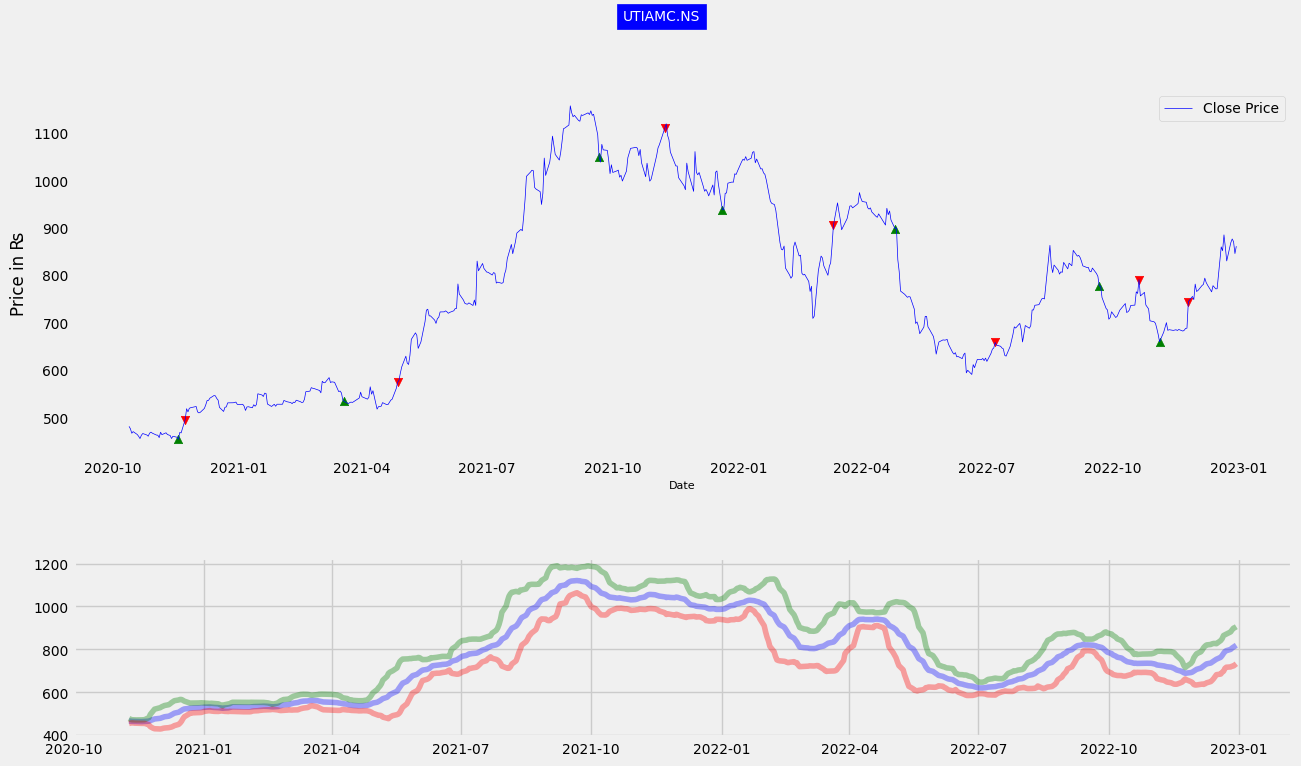

In [64]:
############# Bollinger Bands Implementation #############


def bb_strategy(data):
    bbBuy = []
    bbSell = []
    position = False
    bb = ta.bbands(data['Adj Close'], length=20,std=2)
    data = pd.concat([data, bb], axis=1).reindex(data.index)

    for i in range(len(data)):
        if data['Adj Close'][i] < data['BBL_20_2.0'][i]:
            if position == False :
                bbBuy.append(data['Adj Close'][i])
                bbSell.append(np.nan)
                position = True
            else:
                bbBuy.append(np.nan)
                bbSell.append(np.nan)
        elif data['Adj Close'][i] > data['BBU_20_2.0'][i]:
            if position == True:
                bbBuy.append(np.nan)
                bbSell.append(data['Adj Close'][i])
                position = False #To indicate that I actually went there
            else:
                bbBuy.append(np.nan)
                bbSell.append(np.nan)
        else :
            bbBuy.append(np.nan)
            bbSell.append(np.nan)

    data['bb_Buy_Signal_price'] = bbBuy
    data['bb_Sell_Signal_price'] = bbSell

    return data

#storing the function
data = bb_strategy(data)

#plot
fig, ax1 = plt.subplots(figsize=(14,8))
fig.suptitle(stocksymbols[0], fontsize=10, backgroundcolor='blue', color='white')
ax1 = plt.subplot2grid((14, 8), (0, 0), rowspan=8, colspan=14)
ax2 = plt.subplot2grid((14, 12), (10, 0), rowspan=6, colspan=14)
ax1.set_ylabel('Price in ₨')
ax1.plot(data['Adj Close'],label='Close Price', linewidth=0.5, color='blue')
ax1.scatter(data.index, data['bb_Buy_Signal_price'], color='green', marker='^', alpha=1)
ax1.scatter(data.index, data['bb_Sell_Signal_price'], color='red', marker='v', alpha=1)
ax1.legend()
ax1.grid()
ax1.set_xlabel('Date', fontsize=8)

ax2.plot(data['BBM_20_2.0'], label='Middle', color='blue', alpha=0.35) #middle band
ax2.plot(data['BBU_20_2.0'], label='Upper', color='green', alpha=0.35) #Upper band
ax2.plot(data['BBL_20_2.0'], label='Lower', color='red', alpha=0.35) #lower band
ax2.fill_between(data.index, data['BBL_20_2.0'], data['BBU_20_2.0'], alpha=0.1)
ax2.legend(loc='upper left')
ax2.grid()
plt.show()
